# Database comparisons
The purpose of this notebook is to evaluate classification accuracy between different reference databases. Select mock community sequences are taxonomically classified using two or more different reference databases, e.g., Greengenes 13_8 [trimmed to 250 nt](./generate-tax-assignments.ipynb) and the same database [trimmed to 150 nt](./generate-tax-assignments-trimmed-dbs.ipynb). [This notebook](./generate-tax-assignments-trimmed-dbs.ipynb) can also be modified to provide taxonomic classification with any number of desired reference databases/versions. Limit the analysis to only a few mock communities and method/parameter combinations; the goal here is to compare the databases, not the methods.

In the example below, we compare RDP classifications of a single 16S rRNA dataset (mock-3) and a single fungal ITS dataset (mock-9) using three different reference databases: reference sequences that are full length (e.g., full 16S rRNA gene), trimmed to 250 nt (approximately full V4 gene), or trimmed to 150 nt or 100 nt (length of sequence read).

Prepare the environment
-----------------------

First we'll import various functions that we'll need for generating the report. 

In [1]:
%matplotlib inline
from os.path import join, expandvars
import pandas as pd
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           boxplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis)
from tax_credit.eval_framework import (evaluate_results,
                                       method_by_reference_comparison)

Configure local environment-specific values
-------------------------------------------

**This is the only cell that you will need to edit to generate basic reports locally.** After editing this cell, you can run all cells in this notebook to generate your analysis report. This will take a few minutes to run, as results are computed at multiple taxonomic levels.

Values in this cell will not need to be changed, with the exception of ``project_dir``, to generate the default results contained within tax-credit. To analyze results separately from the tax-credit precomputed results, other variables in this cell will need to be set.

In [2]:
## project_dir should be the directory where you've downloaded (or cloned) the 
## short-read-tax-assignment repository. 
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")

## expected_results_dir contains expected composition data in the structure
## expected_results_dir/<dataset name>/<reference name>/expected/
expected_results_dir = join(project_dir, "data/precomputed-results/", "mock-community")

## mock_results_fp designates the files to which summary results are written.
## If this file exists, it can be read in to generate results plots, instead
## of computing new scores.
mock_results_fp = join(expected_results_dir, 'mock_results.tsv')

## results_dirs should contain the directory or directories where
## results can be found. By default, this is the same location as expected 
## results included with the project. If other results should be included, 
## absolute paths to those directories should be added to this list.
results_dirs = [expected_results_dir]

## Minimum number of times an OTU must be observed for it to be included in analyses. Edit this
## to analyze the effect of the minimum count on taxonomic results.
min_count = 1

## Define the range of taxonomic levels over which to compute accuracy scores.
## The default given below will compute order (level 2) through species (level 6)
taxonomy_level_range = range(2,7)

Find mock community pre-computed tables, expected tables, and "query" tables
----------------------------------------------------------------------------

Next we'll use the paths defined above to find all of the tables that will be compared. These include the *pre-computed result* tables (i.e., the ones that the new methods will be compared to), the *expected result* tables (i.e., the tables containing the known composition of the mock microbial communities), and the *query result* tables (i.e., the tables generated with the new method(s) that we want to compare to the *pre-computed result* tables).

In [3]:
mock_results = evaluate_results(results_dirs, 
                                expected_results_dir, 
                                mock_results_fp, 
                                taxonomy_level_range=range(2,7), 
                                min_count=1,
                                taxa_to_keep=None, 
                                md_key='taxonomy', 
                                subsample=False,
                                force=False)

/Users/nbokulich/Desktop/projects/short-read-tax-assignment/data/precomputed-results/mock-community/mock_results.tsv already exists.
Reading in pre-computed evaluation results.
To overwrite, set force=True


Restrict analyses to a set of datasets used for purpose of reference database comparisons.

In [4]:
mock_results = mock_results[mock_results['Method'] == 'rdp']
mock_results = mock_results[mock_results['Dataset'].isin(['mock-3', 'mock-9'])]

Evalution 1: Compute and summarize precision, recall, and F-measure for mock communities
----------------------------------------------------------------------------------------

In this evaluation, we compute and summarize precision, recall, and F-measure of each result (pre-computed and query) based on the known composition of the mock communities. We then summarize the results in two ways: first with boxplots, and second with a table of the top methods based on their F-measures. 

This is a qualitative evaluation, effectively telling us about the ability of the different methods to report the taxa that are present in each sample. These metrics are not concerned with the abundance of the different taxa.

As a first step, we will evaluate how accuracy metrics perform at each taxonomic level for each method within each reference dataset type.

In [5]:
color_pallette = {'gg_13_8_otus':'seagreen', 'gg_13_8_otus_trim150':'blue', 'gg_13_8_otus_full16S':'orange',
                  'unite_20.11.2016':'seagreen', 'unite_20.11.2016_trim100':'blue', 'unite_20.11.2016_fullITS':'orange', 'unite_20.11.2016_trim150':'red'}

y_vars = ["Precision", "Recall", "F-measure", "Pearson r", "Spearman r"]

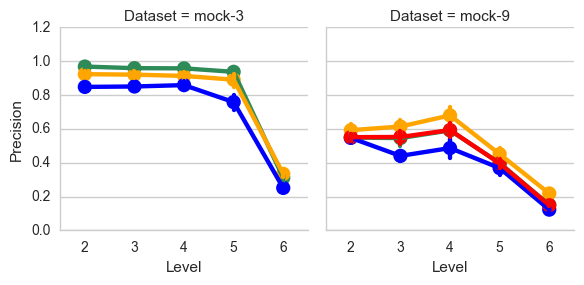

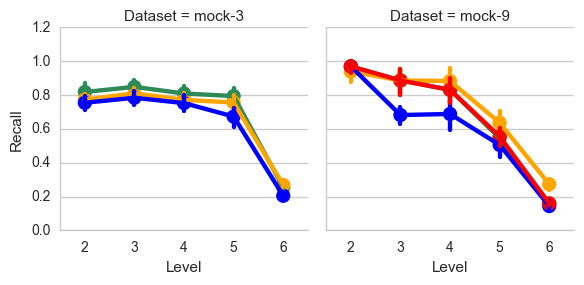

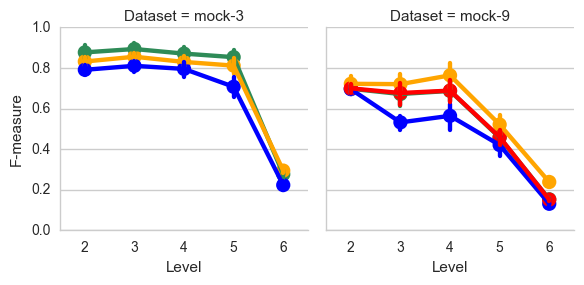

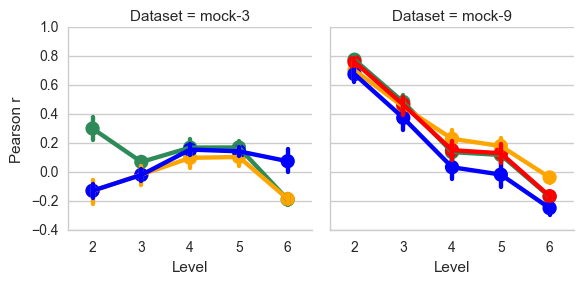

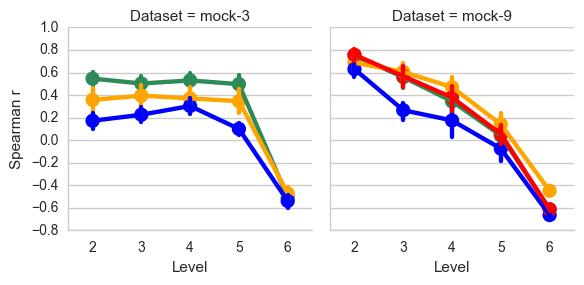

In [6]:
pointplot_from_data_frame(mock_results, "Level", y_vars, 
                          group_by="Dataset", color_by="Reference",
                          color_pallette=color_pallette)

Kruskal-Wallis FDR-corrected p-values comparing reference database / method combinations at each level of taxonomic assignment

In [7]:
result = per_level_kruskal_wallis(mock_results, y_vars, group_by='Reference', 
                                  dataset_col='Dataset', level_name='Level',
                                  levelrange=range(2,7), alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset    Variable             2             3             4             5  \
0  mock-3   Precision  7.300849e-11  3.289758e-10  9.955311e-08  3.622156e-10   
1  mock-3      Recall  7.608052e-02  4.982334e-02  2.277473e-01  2.864736e-03   
2  mock-3   F-measure  9.377643e-03  6.405929e-03  2.006797e-02  2.755249e-05   
3  mock-3   Pearson r  1.910563e-11  6.660420e-02  3.384309e-01  2.544336e-01   
4  mock-3  Spearman r  3.382350e-07  2.488608e-04  1.878088e-03  4.820878e-09   
5  mock-9   Precision  6.660420e-02  8.227863e-08  5.126568e-07  2.006797e-02   
6  mock-9      Recall  9.992374e-01  1.468345e-08  2.981557e-05  5.188099e-04   
7  mock-9   F-measure  5.378719e-02  1.007645e-08  3.490550e-07  1.395727e-03   
8  mock-9   Pearson r  2.195232e-02  6.660420e-02  1.565004e-02  2.011123e-03   
9  mock-9  Spearman r  1.433542e-03  1.197854e-08  1.028013e-02  3.677553e-03   

              6  
0  4.510530e-05  
1  2.082400e-04  
2  1.053979e-05  
3  3.086191e-06  
4  5.896596e-01  
5  1.147331e-09  
6  3.902171e-08  
7  2.377147e-07  
8  3.698437e-10  
9  1.147331e-09

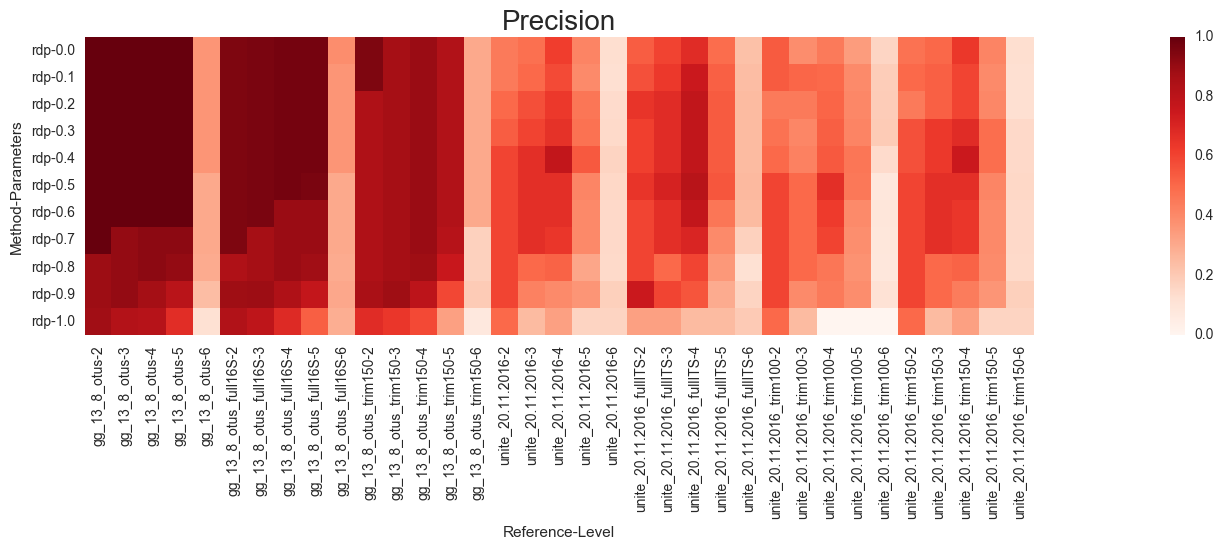

In [8]:
heatmap_from_data_frame(mock_results, metric="Precision", rows=["Method", "Parameters"], cols=["Reference", "Level"])

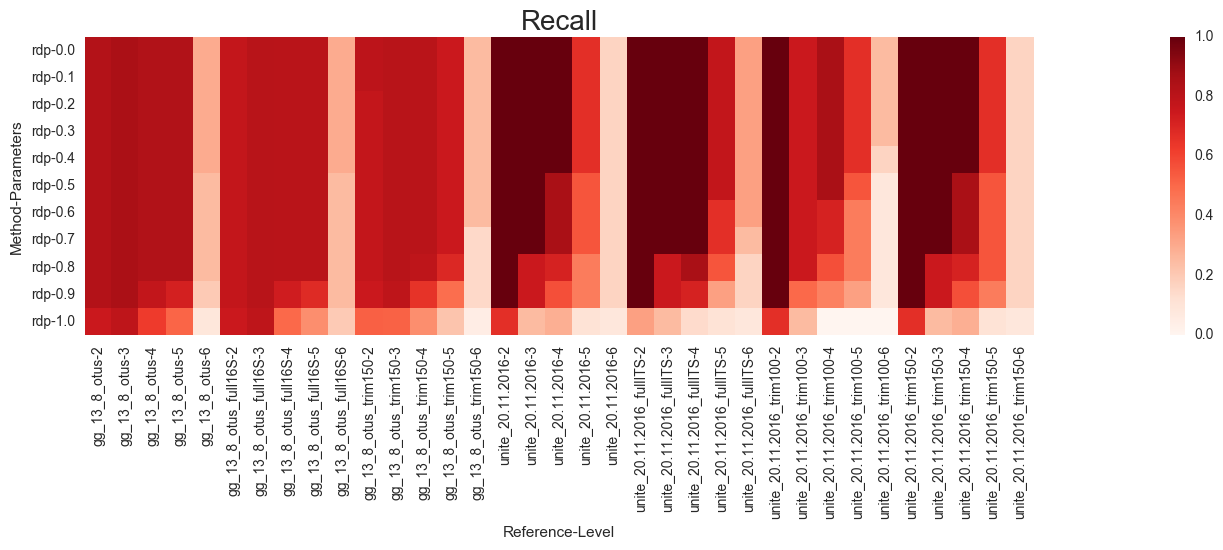

In [9]:
heatmap_from_data_frame(mock_results, metric="Recall", rows=["Method", "Parameters"], cols=["Reference", "Level"])

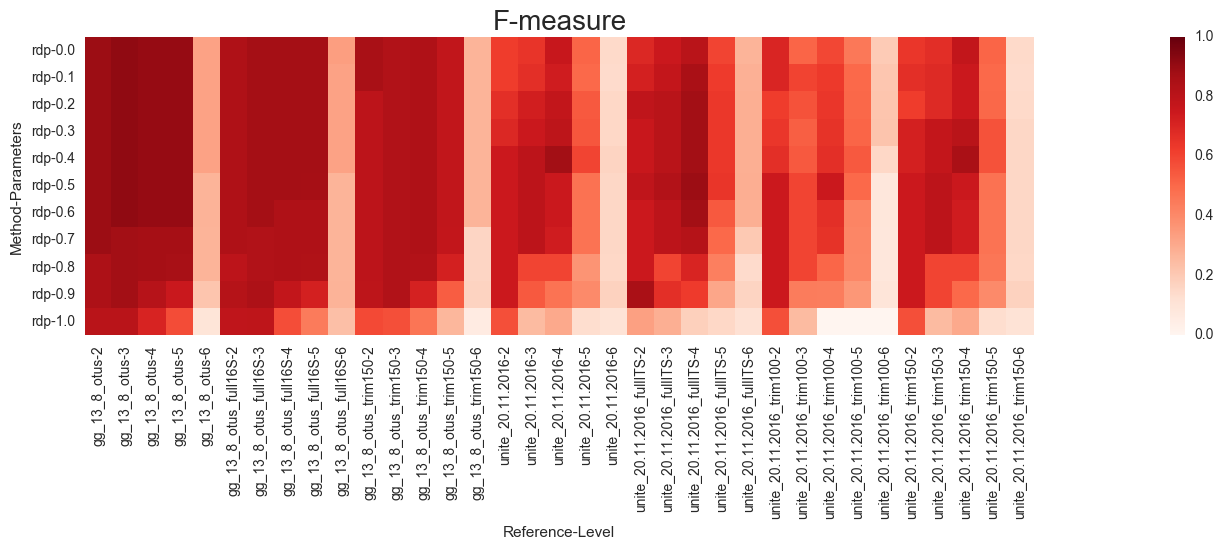

In [10]:
heatmap_from_data_frame(mock_results, metric="F-measure", rows=["Method", "Parameters"], cols=["Reference", "Level"])

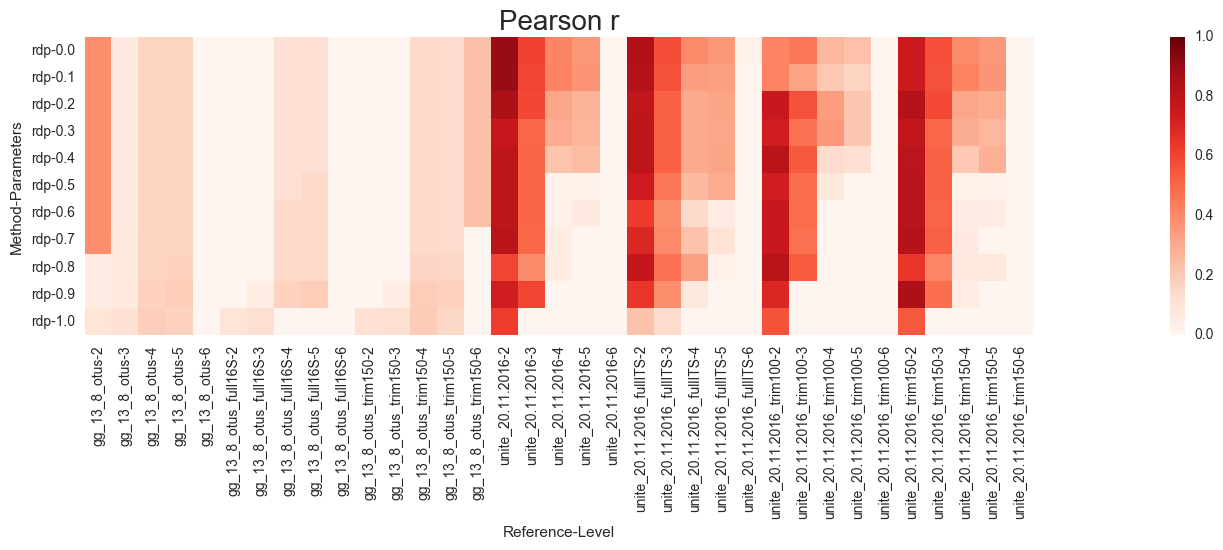

In [11]:
heatmap_from_data_frame(mock_results, metric="Pearson r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

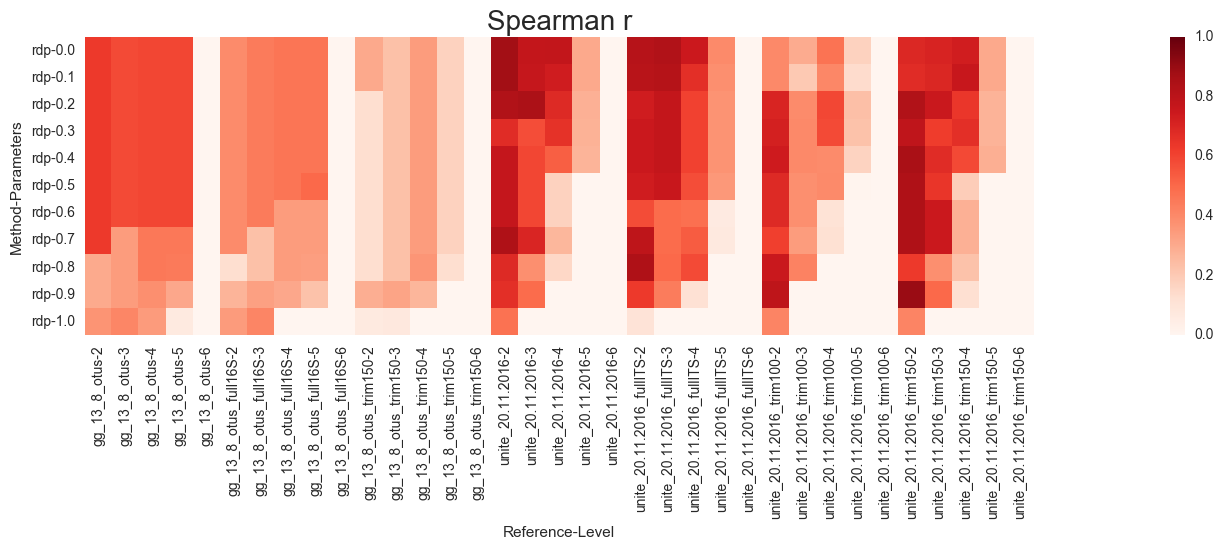

In [12]:
heatmap_from_data_frame(mock_results, metric="Spearman r", rows=["Method", "Parameters"], cols=["Reference", "Level"])

Now we will focus on results at genus level (for species level, change to level 6)

In [13]:
mock_results_6 = mock_results[mock_results['Level'] == 5]

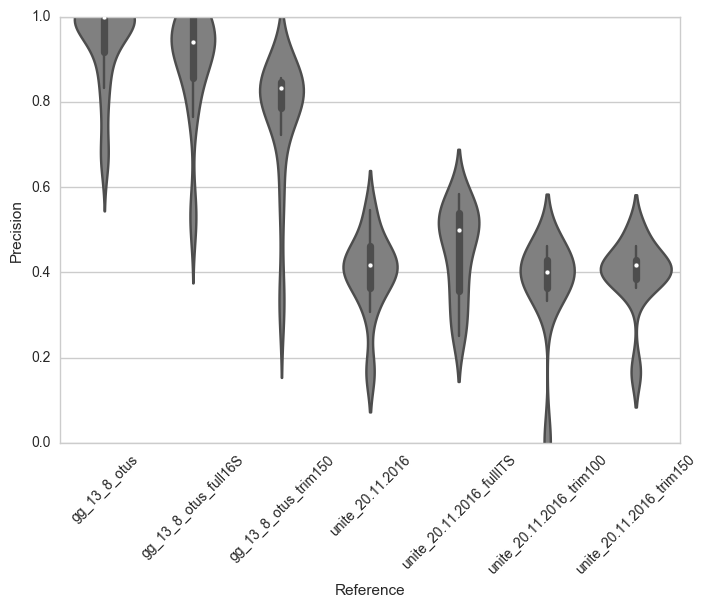

In [14]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Precision")

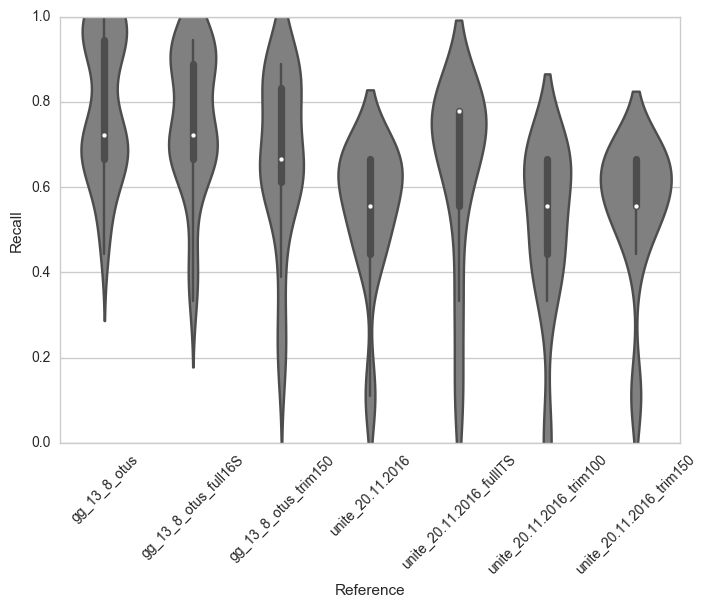

In [15]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Recall")

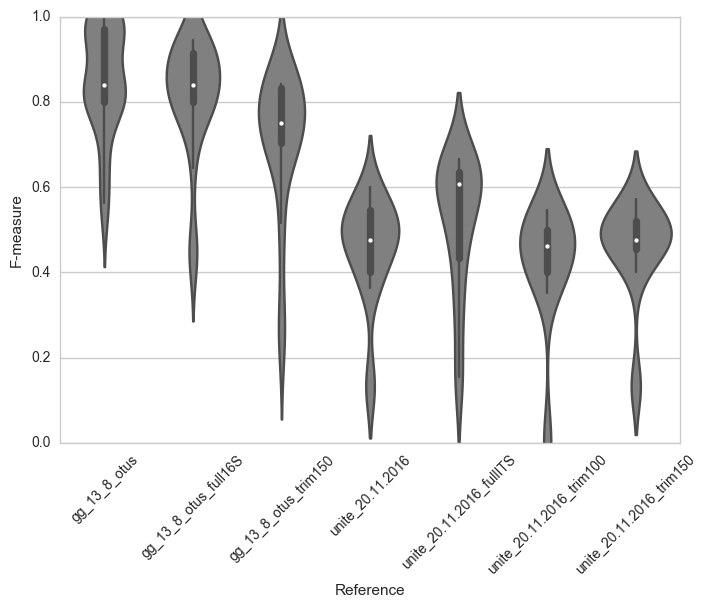

In [16]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="F-measure")

In [17]:
method_by_reference_comparison(mock_results)

Reference  Level Method Parameters  Precision    Recall  \
3659               gg_13_8_otus      4    rdp        0.6   1.000000  1.000000   
4859       gg_13_8_otus_full16S      4    rdp        0.1   0.944444  0.944444   
5199       gg_13_8_otus_trim150      4    rdp        0.7   0.850000  0.944444   
3663               gg_13_8_otus      5    rdp        0.6   1.000000  1.000000   
4863       gg_13_8_otus_full16S      5    rdp        0.1   0.944444  0.944444   
5123       gg_13_8_otus_trim150      5    rdp        0.3   0.800000  0.888889   
3548               gg_13_8_otus      6    rdp        0.0   0.461538  0.300000   
4848       gg_13_8_otus_full16S      6    rdp        0.0   0.500000  0.300000   
5168       gg_13_8_otus_trim150      6    rdp        0.5   0.384615  0.250000   
11263          unite_20.11.2016      4    rdp        0.4   0.777778  1.000000   
12208  unite_20.11.2016_fullITS      4    rdp        0.2   0.875000  1.000000   
12417  unite_20.11.2016_trim100      4    rdp        0.5   0.666667  0.857143   
12566  unite_20.11.2016_trim150      4    rdp        0.4   0.777778  1.000000   
11266          unite_20.11.2016      5    rdp        0.4   0.545455  0.666667   
12256  unite_20.11.2016_fullITS      5    rdp        0.5   0.583333  0.777778   
12404  unite_20.11.2016_trim100      5    rdp        0.4   0.461538  0.666667   
12554  unite_20.11.2016_trim150      5    rdp        0.3   0.500000  0.666667   
11344          unite_20.11.2016      6    rdp        0.9   0.181818  0.166667   
12244  unite_20.11.2016_fullITS      6    rdp        0.4   0.266667  0.333333   
12362  unite_20.11.2016_trim100      6    rdp        0.1   0.200000  0.250000   
12649  unite_20.11.2016_trim150      6    rdp        0.9   0.181818  0.166667   

       F-measure  
3659    1.000000  
4859    0.944444  
5199    0.894737  
3663    1.000000  
4863    0.944444  
5123    0.842105  
3548    0.363636  
4848    0.375000  
5168    0.303030  
11263   0.875000  
12208   0.933333  
12417   0.750000  
12566   0.875000  
11266   0.600000  
12256   0.666667  
12404   0.545455  
12554   0.571429  
11344   0.173913  
12244   0.296296  
12362   0.222222  
12649   0.173913

Evaluation 2: Compute and summarize correlations between observed and known mock community structure
----------------------------------------------------------------------------------------------------

In this evaluation, we compute and summarize the correlation between each result (pre-computed and query) and the known composition of the mock communities. We then summarize the results in two ways: first with a series of boxplots of correlation coefficients by method; and second with a table of the top methods based on their Pearson correlation coefficient. 

This is a quantitative evaluation, which tells us about the ability of the different methods to report the taxa that are present in each sample and accurately assess their abundance. Because many factors can affect the observed abundance of taxa beyond the accuracy of the taxonomic assigner (e.g., primer bias), the correlation coefficients are frequently low, but we expect that their relative values are informative in understanding which taxonomic assigners are more correct than others.

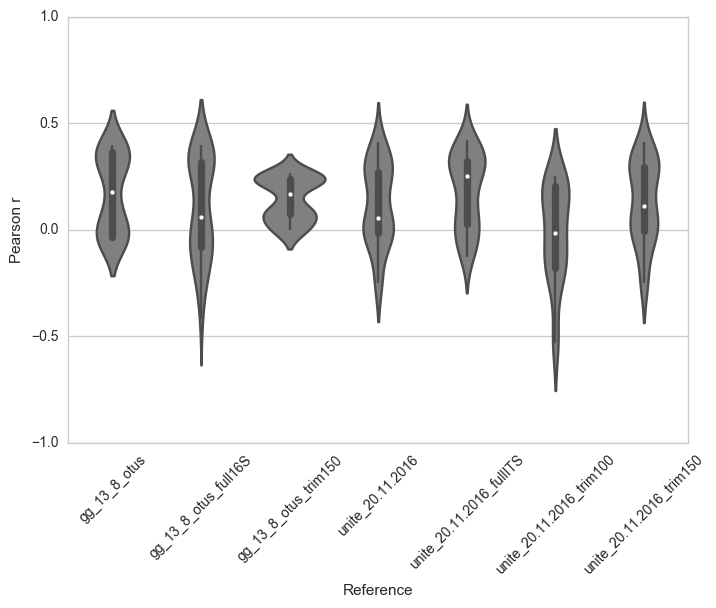

In [18]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Pearson r", y_min=None)

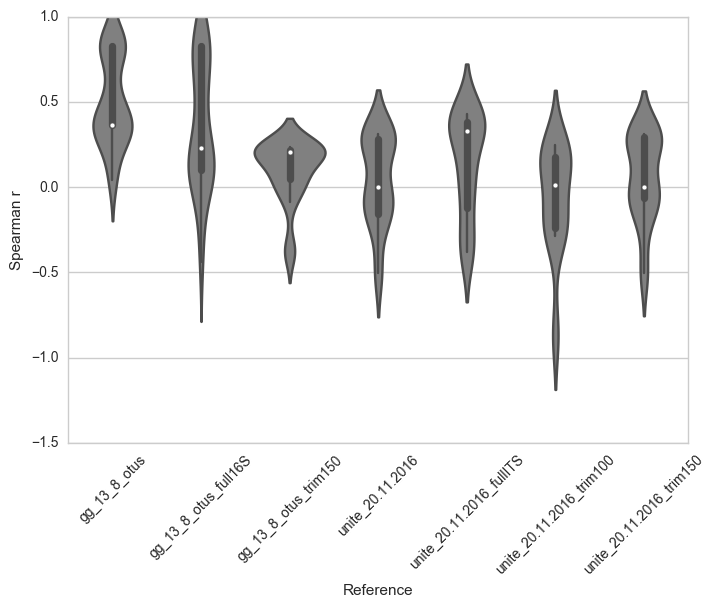

In [19]:
boxplot_from_data_frame(mock_results_6, group_by="Reference", metric="Spearman r", y_min=None)

In [20]:
method_by_reference_comparison(mock_results, sort_field="Spearman r",
                               display_fields=("Reference", "Level",
                                               "Method", "Parameters",
                                               "Pearson r", "Spearman r"))

Reference  Level Method Parameters  Pearson r  \
3640               gg_13_8_otus      4    rdp        0.5   0.391337   
4940       gg_13_8_otus_full16S      4    rdp        0.5   0.391337   
5160       gg_13_8_otus_trim150      4    rdp        0.5   0.286989   
3644               gg_13_8_otus      5    rdp        0.5   0.391337   
4944       gg_13_8_otus_full16S      5    rdp        0.5   0.328646   
5223       gg_13_8_otus_trim150      5    rdp        0.8   0.101424   
3548               gg_13_8_otus      6    rdp        0.0  -0.078212   
4848       gg_13_8_otus_full16S      6    rdp        0.0  -0.021617   
5168       gg_13_8_otus_trim150      6    rdp        0.5   0.436463   
11202          unite_20.11.2016      4    rdp        0.0   0.504201   
12177  unite_20.11.2016_fullITS      4    rdp        0.0   0.509576   
12371  unite_20.11.2016_trim100      4    rdp        0.2   0.356728   
12523  unite_20.11.2016_trim150      4    rdp        0.1   0.333269   
11221          unite_20.11.2016      5    rdp        0.1   0.334900   
12180  unite_20.11.2016_fullITS      5    rdp        0.0   0.416260   
12375  unite_20.11.2016_trim100      5    rdp        0.2   0.224702   
12526  unite_20.11.2016_trim150      5    rdp        0.1   0.335030   
11222          unite_20.11.2016      6    rdp        0.1  -0.042765   
12183  unite_20.11.2016_fullITS      6    rdp        0.0   0.066910   
12348  unite_20.11.2016_trim100      6    rdp        0.0  -0.050655   
12527  unite_20.11.2016_trim150      6    rdp        0.1  -0.042655   

       Spearman r  
3640     0.834849  
4940     0.834849  
5160     0.562133  
3644     0.834849  
4944     0.834849  
5223     0.235419  
3548    -0.212880  
4848    -0.100261  
5168    -0.266088  
11202    0.800656  
12177    0.784370  
12371    0.596348  
12523    0.767912  
11221    0.312077  
12180    0.429480  
12375    0.250478  
12526    0.312077  
11222   -0.552481  
12183   -0.357226  
12348   -0.468730  
12527   -0.552581